## LLM-Powered Natural Language Explanations

This notebook demonstrates how to generate human-readable explanations using Large Language Models (LLMs).

**Purpose**: Convert technical model explanations (SHAP, LIME) into natural language that anyone can understand.

**How it works**:
1. **Input**: Takes prediction results, SHAP/LIME feature importance, and global context
2. **LLM Processing**: Uses a language model (Microsoft Phi-2) to generate explanations
3. **Output**: Natural language summary explaining:
   - The risk level and why
   - Key factors driving the prediction
   - How this case compares to typical patterns
   - Actionable recommendations

**Key Features**:
- **Automatic Model Download**: Downloads LLM from HuggingFace if not present
- **Consistent with App**: Uses the same logic as the web application
- **Fast Local Computation**: Generates explanations quickly using local model

**Output**: Natural language explanations that make model predictions understandable to non-technical users.


## Imports and Setup


In [1]:
import os
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import shap

from lime.lime_tabular import LimeTabularExplainer
from tensorflow import keras
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

ROOT = os.path.abspath(os.getcwd())
PROJECT_ROOT = os.path.abspath(os.path.join(ROOT, '..'))
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
DATASET_DIR = os.path.join(PROJECT_ROOT, 'dataset')
ARTIFACTS_DIR = os.path.join(PROJECT_ROOT, 'artifacts')
SHAP_DIR = os.path.join(ARTIFACTS_DIR, '04_shap_images')
ADV_DIR = os.path.join(ARTIFACTS_DIR, '04b_images')
LLM_DIR = os.path.join(MODELS_DIR, 'LLM_MODEL')

# Ensure LLM directory exists from the start
os.makedirs(LLM_DIR, exist_ok=True)

print("Imports successful.")

Imports successful.


## Load Training Data and Feature Names


In [2]:
X_train = pd.read_pickle(os.path.join(DATASET_DIR, 'X_train.pkl'))
feature_names = X_train.columns.tolist()

print(f"Loaded training data: {X_train.shape}")
print(f"Feature names: {len(feature_names)}")


Loaded training data: (26064, 17)
Feature names: 17


## Load Preprocessing Components


In [3]:
with open(os.path.join(MODELS_DIR, 'RobutScaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)
with open(os.path.join(MODELS_DIR, 'LabelEncoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)
with open(os.path.join(MODELS_DIR, 'OneHotEncoder.pkl'), 'rb') as f:
    one_hot_encoder = pickle.load(f)

print("Preprocessing components loaded.")


Preprocessing components loaded.


## Load Models


In [4]:
# Try different possible filenames for models
base_models_file = None
for filename in ['ensemble_base_models_neural.joblib', 'multiscale_base_models.joblib']:
    path = os.path.join(MODELS_DIR, filename)
    if os.path.exists(path):
        base_models_file = path
        break

if base_models_file is None:
    raise FileNotFoundError(f"Base models file not found. Checked: ensemble_base_models_neural.joblib, multiscale_base_models.joblib")

meta_model_file = None
for filename in ['meta_learner_neural.h5', 'multiscale_meta_learner.h5']:
    path = os.path.join(MODELS_DIR, filename)
    if os.path.exists(path):
        meta_model_file = path
        break

if meta_model_file is None:
    raise FileNotFoundError(f"Meta model file not found. Checked: meta_learner_neural.h5, multiscale_meta_learner.h5")

neural_model_file = None
for filename in ['neural_network_advanced.h5', 'dcn_neural.h5', 'residual_neural.h5']:
    path = os.path.join(MODELS_DIR, filename)
    if os.path.exists(path):
        neural_model_file = path
        break

if neural_model_file is None:
    raise FileNotFoundError(f"Neural network model file not found. Checked: neural_network_advanced.h5, dcn_neural.h5, residual_neural.h5")

base_models = joblib.load(base_models_file)
meta_model = keras.models.load_model(meta_model_file, compile=False)
neural_model = keras.models.load_model(neural_model_file, compile=False)

print("Models loaded successfully.")


Models loaded successfully.


## Load Global Explainability Insights


In [5]:
with open(os.path.join(SHAP_DIR, 'shap_feature_importance.json'), 'r') as f:
    shap_global = json.load(f)
with open(os.path.join(SHAP_DIR, 'lime_feature_importance.json'), 'r') as f:
    lime_global = json.load(f)
with open(os.path.join(SHAP_DIR, 'combined_feature_importance.json'), 'r') as f:
    combined_global = json.load(f)
with open(os.path.join(ADV_DIR, 'advanced_explainability_report.json'), 'r') as f:
    advanced_report = json.load(f)

shap_importance_dict = {item['feature']: item['importance'] for item in shap_global}
lime_importance_dict = {item['feature']: item['importance'] for item in lime_global}
combined_importance_dict = {item['feature']: item['combined_importance'] for item in combined_global}

sensitivity_data = advanced_report.get('sensitivity_analysis', {})
model_comparison_data = advanced_report.get('model_specific_analysis', {}).get('top_features_by_model', {})

print("Global explainability insights loaded.")


Global explainability insights loaded.


## Input Data Entry

Edit values below to test different scenarios.


In [6]:
person_age = 34
person_income = 92000
person_home_ownership = "RENT"
person_emp_length = 5.0
loan_intent = "VENTURE"
loan_grade = "B"
loan_amnt = 92000
loan_int_rate = 13.5
loan_percent_income = 0.24
cb_person_default_on_file = "N"
cb_person_cred_hist_length = 6

manual_input = {
    "person_age": person_age,
    "person_income": person_income,
    "person_home_ownership": person_home_ownership,
    "person_emp_length": person_emp_length,
    "loan_intent": loan_intent,
    "loan_grade": loan_grade,
    "loan_amnt": loan_amnt,
    "loan_int_rate": loan_int_rate,
    "loan_percent_income": loan_percent_income,
    "cb_person_default_on_file": cb_person_default_on_file,
    "cb_person_cred_hist_length": cb_person_cred_hist_length
}

manual_df = pd.DataFrame([manual_input])
print("Input data:")
display(manual_df)


Input data:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,34,92000,RENT,5.0,VENTURE,B,92000,13.5,0.24,N,6


## Data Preprocessing


In [7]:
numeric_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length'
]

numeric_scaled = scaler.transform(manual_df[numeric_cols])
numeric_scaled = pd.DataFrame(numeric_scaled, columns=numeric_cols)

ordinal_cols = ['loan_grade']
ordinal_encoded = label_encoder.transform(manual_df[ordinal_cols].values.ravel())
ordinal_df = pd.DataFrame(ordinal_encoded, columns=ordinal_cols)

nominal_cols = ['person_home_ownership', 'loan_intent']
nominal_encoded = one_hot_encoder.transform(manual_df[nominal_cols])
nominal_feature_names = one_hot_encoder.get_feature_names_out(nominal_cols)
nominal_df = pd.DataFrame(nominal_encoded, columns=nominal_feature_names)

binary_cols = ['cb_person_default_on_file']
binary_encoded = manual_df[binary_cols].replace({'Y': 1, 'N': 0}).values
binary_df = pd.DataFrame(binary_encoded, columns=binary_cols)

categorical_encoded = pd.concat([ordinal_df, nominal_df, binary_df], axis=1)
manual_processed = pd.concat([numeric_scaled, categorical_encoded], axis=1)
manual_processed = manual_processed.reindex(columns=feature_names, fill_value=0)

print("Preprocessed data ready.")


Preprocessed data ready.


## Ensemble Prediction

Stacking: Base models predict probabilities, meta-learner combines them.


In [8]:
# Stacking Ensemble Prediction: Two-stage approach for robust predictions
# Stage 1: Base models generate probability predictions independently
# Each model captures different patterns - tree models (XGBoost, LightGBM, CatBoost) 
# handle non-linear relationships, while neural network captures complex interactions
pred_xgb_deep = base_models['xgb_deep'].predict_proba(manual_processed)[:, 1]  # Deep tree model
pred_xgb_shallow = base_models['xgb_shallow'].predict_proba(manual_processed)[:, 1]  # Shallow tree model
pred_lgbm = base_models['lgbm_fast'].predict_proba(manual_processed)[:, 1]  # Fast gradient boosting
pred_catboost = base_models['catboost_robust'].predict_proba(manual_processed)[:, 1]  # Robust gradient boosting
pred_neural = neural_model.predict(manual_processed.values, verbose=0).ravel()  # Deep learning model

# Stage 2: Stack base model predictions into feature vector for meta-learner
# Meta-learner learns optimal combination weights from base model predictions
# This approach reduces overfitting and improves generalization
stacked_inputs = np.column_stack([
    pred_xgb_deep, pred_xgb_shallow, pred_lgbm,
    pred_catboost, pred_neural
])

# Meta-learner combines base predictions into final probability score
# Returns single probability value between 0 and 1
final_probability = float(meta_model.predict(stacked_inputs, verbose=0).ravel()[0])

# Risk classification based on probability thresholds
# HIGH: >50% default probability (high risk)
# MODERATE: 30-50% default probability (medium risk)
# LOW: <30% default probability (low risk)
risk_level = "HIGH" if final_probability > 0.5 else "MODERATE" if final_probability > 0.3 else "LOW"

print(f"Default Probability: {final_probability:.4f} ({final_probability*100:.2f}%)")
print(f"Risk Level: {risk_level}")


Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "d:\Conda\envs\final_last\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "d:\Conda\envs\final_last\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "d:\Conda\envs\final_last\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "d:\Conda\envs\final_last\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 4: invalid continuation byte


Default Probability: 0.9402 (94.02%)
Risk Level: HIGH


## SHAP Explanation Setup

PermutationExplainer shuffles features to measure marginal contribution.


In [9]:
def ensemble_predict_proba(X):
    """
    Wrapper function for ensemble prediction used by SHAP explainer.
    
    SHAP needs a function that takes input data and returns probability scores.
    This function replicates the stacking ensemble logic: base models predict,
    then meta-learner combines their outputs.
    
    Parameters:
        X: Input data as numpy array or pandas DataFrame. Shape: (n_samples, n_features)
           Can be single row or multiple rows (SHAP may pass multiple samples)
    
    Returns:
        numpy array: Probability scores for default class. Shape: (n_samples,)
                     Values range from 0 to 1, where 1 means high default risk
    """
    # Convert DataFrame to numpy array if needed (SHAP sometimes passes arrays)
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Get predictions from all base models (stage 1 of stacking)
    pred_xgb_deep = base_models['xgb_deep'].predict_proba(X)[:, 1]
    pred_xgb_shallow = base_models['xgb_shallow'].predict_proba(X)[:, 1]
    pred_lgbm = base_models['lgbm_fast'].predict_proba(X)[:, 1]
    pred_catboost = base_models['catboost_robust'].predict_proba(X)[:, 1]
    pred_neural = neural_model.predict(X, verbose=0).ravel()
    
    # Stack predictions for meta-learner (stage 2 of stacking)
    base_preds = np.column_stack([pred_xgb_deep, pred_xgb_shallow, pred_lgbm, pred_catboost, pred_neural])
    final_pred = meta_model.predict(base_preds, verbose=0).ravel()
    return final_pred

# SHAP PermutationExplainer: Measures feature importance by permuting feature values
# How it works: For each feature, randomly shuffle its values in background data,
# then measure how much the prediction changes. Average change = feature importance.
# Background data provides reference distribution for fair comparison
SHAP_BACKGROUND_SIZE = 50  # Small sample for faster computation (SHAP can be slow)
shap_background = X_train.sample(n=min(SHAP_BACKGROUND_SIZE, len(X_train)), random_state=42).values

# Create explainer with our ensemble function and background data
shap_explainer = shap.PermutationExplainer(ensemble_predict_proba, shap_background)

# Compute SHAP values for our test case
# SHAP values show how much each feature contributes to the prediction
# Positive value = feature increases default probability
# Negative value = feature decreases default probability
# Magnitude = strength of contribution
shap_values_local = shap_explainer(manual_processed.values)

# Extract SHAP values into dictionary for easier processing
shap_local_dict = {}
for i, feat in enumerate(feature_names):
    shap_local_dict[feat] = float(shap_values_local.values[0, i])

# Convert to list format and sort by absolute importance (most influential first)
shap_features = [
    {"feature": feat, "shap_value": val}
    for feat, val in shap_local_dict.items()
]
shap_features.sort(key=lambda x: abs(x["shap_value"]), reverse=True)

print("SHAP values computed.")
print(f"Top 5 SHAP features: {[f['feature'] for f in shap_features[:5]]}")


PermutationExplainer explainer: 2it [00:12, 12.22s/it]               

SHAP values computed.
Top 5 SHAP features: ['loan_amnt', 'person_home_ownership_RENT', 'loan_percent_income', 'loan_intent_VENTURE', 'cb_person_cred_hist_length']


## LIME Explanation Setup

LIME fits local linear model around the instance.


In [10]:
def _probabilities_for_lime(data):
    """
    Converts input data to probability predictions for LIME explainer.
    
    LIME requires a function that returns probabilities for each class.
    This function wraps our ensemble predictor and formats output as [prob_class0, prob_class1].
    
    Parameters:
        data: numpy array of shape (n_samples, n_features)
              LIME passes perturbed versions of the original instance
    
    Returns:
        numpy array: Shape (n_samples, 2) with [prob_no_default, prob_default] for each sample
                     First column = probability of no default (1 - default_prob)
                     Second column = probability of default
    """
    # Convert to DataFrame with proper column names (LIME passes raw arrays)
    frame = pd.DataFrame(data, columns=feature_names)
    # Get default probabilities from ensemble
    scores = ensemble_predict_proba(frame)
    # Return both class probabilities: [prob_class0, prob_class1]
    return np.column_stack([1 - scores, scores])

def _clean_feature_name(condition, feature_names):
    """
    Extracts clean feature name from LIME's condition string.
    
    LIME returns conditions like "loan_amnt <= 50000" or "person_age > 30".
    This function extracts just the feature name by parsing comparison operators.
    Matches the app's logic exactly for consistency.
    
    Parameters:
        condition: str - LIME condition string (e.g., "loan_amnt <= 50000")
        feature_names: list - Valid feature names to match against
    
    Returns:
        str or None: Clean feature name if found, None otherwise
    """
    # Try to find feature by splitting on comparison operators
    # LIME uses operators like <=, >=, >, <, ==, !=
    tokens = [" <=", " >=", " >", " <", " ==", " !="]
    for token in tokens:
        if token in condition:
            # Extract part before operator
            candidate = condition.split(token)[0].strip()
            if candidate in feature_names:
                return candidate
    # Fallback: check if any feature name appears in condition string
    for feat in feature_names:
        if feat in condition:
            return feat
    return None

# LIME (Local Interpretable Model-agnostic Explanations): Fits local linear model
# How it works: Creates perturbed samples around the instance, gets predictions,
# then fits a simple linear model to approximate the complex ensemble locally.
# The linear model's coefficients become feature importance scores.
LIME_SAMPLE_SIZE = 100  # Number of background samples for LIME
lime_background = X_train.sample(n=min(LIME_SAMPLE_SIZE, len(X_train)), random_state=42).values

# Create LIME explainer with background data and feature names
lime_explainer = LimeTabularExplainer(
    lime_background,
    feature_names=feature_names,
    mode='classification',  # Binary classification task
    random_state=42
)

# Generate LIME explanation for our test case
# explain_instance creates perturbed samples, gets predictions, fits linear model
lime_result = lime_explainer.explain_instance(
    manual_processed.values.flatten(),  # Flatten to 1D array (single instance)
    _probabilities_for_lime,  # Function to get predictions
    num_features=min(20, len(feature_names))  # Top 20 features to explain
)

# Parse LIME results: extract feature names and impact values
# LIME returns conditions with impact scores (how much feature affects prediction)
lime_rows = []
for condition, impact in lime_result.as_list():
    name = _clean_feature_name(condition, feature_names)
    if name:
        lime_rows.append((name, float(impact)))

# Sort by absolute impact (most influential features first)
lime_rows.sort(key=lambda item: abs(item[1]), reverse=True)
# Convert to list of dictionaries for easier processing
lime_features = [{"feature": name, "impact": impact} for name, impact in lime_rows]

print("LIME values computed.")
print(f"Top 5 LIME features: {[f['feature'] for f in lime_features[:5]]}")


LIME values computed.
Top 5 LIME features: ['loan_percent_income', 'person_home_ownership_OWN', 'loan_intent_VENTURE', 'person_home_ownership_RENT', 'loan_intent_HOMEIMPROVEMENT']


## Risk Drivers Analysis

Combine LIME and SHAP, average their impacts, identify top risk-increasing and risk-decreasing features.


In [11]:
# Risk Drivers Analysis: Collaboration between LIME and SHAP
# Combining both methods provides more robust feature importance:
# - LIME: Local linear approximation (fast, interpretable)
# - SHAP: Game-theoretic approach (theoretically grounded, consistent)
# Averaging reduces noise and identifies true risk drivers

# Step 1: Combine LIME and SHAP importance scores for each feature
# Create dictionary mapping features to both LIME and SHAP values
combined = {}
# Add LIME impacts (positive = increases risk, negative = decreases risk)
for item in lime_features:
    feat = item["feature"]
    if feat not in combined:
        combined[feat] = {"lime": 0.0, "shap": 0.0}
    combined[feat]["lime"] = item["impact"]

# Add SHAP values (positive = increases risk, negative = decreases risk)
for item in shap_features:
    feat = item["feature"]
    if feat not in combined:
        combined[feat] = {"lime": 0.0, "shap": 0.0}
    combined[feat]["shap"] = item["shap_value"]

# Step 2: Classify features as risk-increasing or risk-decreasing
# Average LIME and SHAP scores to get consensus importance
risk_increasing = []  # Features that increase default probability
risk_decreasing = []  # Features that decrease default probability

for feat, values in combined.items():
    # Average both methods for more robust estimate
    avg_impact = (values["shap"] + values["lime"]) / 2
    if avg_impact > 0:
        # Positive impact = increases risk
        risk_increasing.append({
            "feature": feat,
            "impact": avg_impact,
            "direction": "increasing"
        })
    elif avg_impact < 0:
        # Negative impact = decreases risk (use absolute value for ranking)
        risk_decreasing.append({
            "feature": feat,
            "impact": abs(avg_impact),
            "direction": "decreasing"
        })

# Step 3: Sort by impact magnitude and select top features
# Most influential risk drivers first
risk_increasing.sort(key=lambda x: x["impact"], reverse=True)
risk_decreasing.sort(key=lambda x: x["impact"], reverse=True)

# Keep top 5 in each category for focused analysis
risk_increasing = risk_increasing[:5]
risk_decreasing = risk_decreasing[:5]

print("Top Risk-Increasing Features:")
for item in risk_increasing:
    print(f"  {item['feature']}: +{item['impact']:.4f}")

print("\nTop Risk-Decreasing Features:")
for item in risk_decreasing:
    print(f"  {item['feature']}: -{item['impact']:.4f}")


Top Risk-Increasing Features:
  loan_amnt: +0.3297
  person_home_ownership_RENT: +0.1179
  person_home_ownership_OWN: +0.0815
  loan_percent_income: +0.0743
  cb_person_cred_hist_length: +0.0203

Top Risk-Decreasing Features:
  loan_intent_VENTURE: -0.0720
  person_income: -0.0569
  loan_intent_HOMEIMPROVEMENT: -0.0503
  person_age: -0.0092
  loan_grade: -0.0074


## Global Context for Top Features

Compare local feature importance with global patterns and sensitivity analysis.


In [12]:
# Global Context Analysis: Compare local importance with global patterns
# This bridges local explanations (what matters for THIS case) with global insights
# (what matters GENERALLY). Helps identify unusual patterns vs expected behavior.

# Step 1: Identify top locally important features from LIME and SHAP
# Combine both methods' top features to get comprehensive local view
all_features = lime_features + shap_features
top_feature_names = [item["feature"] for item in all_features[:8] if isinstance(item, dict) and "feature" in item]

# Step 2: Compute global importance ranks from pre-computed global insights
# Global SHAP ranks: How important is this feature across all training data?
shap_ranked = sorted(shap_importance_dict.items(), key=lambda x: x[1], reverse=True)
shap_ranks = {feat: i + 1 for i, (feat, _) in enumerate(shap_ranked)}  # Rank 1 = most important

# Global LIME ranks: How often does LIME identify this as important?
lime_ranked = sorted(lime_importance_dict.items(), key=lambda x: x[1], reverse=True)
lime_ranks = {feat: i + 1 for i, (feat, _) in enumerate(lime_ranked)}  # Rank 1 = most important

# Step 3: Load sensitivity analysis data
# Sensitivity measures how much predictions change when feature values change
# High sensitivity = small changes in feature cause large prediction changes
sensitivity_features = sensitivity_data.get('top_sensitive_features', [])
sensitivity_dict = {item['feature']: item['sensitivity'] for item in sensitivity_features}

# Step 4: Build global context for each locally important feature
# For each feature, compare its local importance with global patterns
global_context = []
for feat in top_feature_names[:8]:
    global_context.append({
        "feature": feat,
        "global_shap_rank": shap_ranks.get(feat),  # None if not in global top features
        "global_lime_rank": lime_ranks.get(feat),  # None if not in global top features
        "sensitivity": sensitivity_dict.get(feat),  # None if not analyzed
    })

# Interpretation guide:
# - Low global rank but high local importance = unusual case (this feature matters here but not generally)
# - High global rank and high local importance = expected pattern (feature is important both locally and globally)
# - High sensitivity = model is very sensitive to changes in this feature
print("Global context for top features:")
for item in global_context:
    print(f"  {item['feature']}: SHAP rank={item['global_shap_rank']}, LIME rank={item['global_lime_rank']}, sensitivity={item['sensitivity']}")


Global context for top features:
  loan_percent_income: SHAP rank=1, LIME rank=3, sensitivity=0.019725577905774117
  person_home_ownership_OWN: SHAP rank=None, LIME rank=1, sensitivity=None
  loan_intent_VENTURE: SHAP rank=5, LIME rank=2, sensitivity=0.003997806925326586
  person_home_ownership_RENT: SHAP rank=4, LIME rank=5, sensitivity=0.00953250378370285
  loan_intent_HOMEIMPROVEMENT: SHAP rank=7, LIME rank=6, sensitivity=0.0033628540113568306
  person_income: SHAP rank=3, LIME rank=8, sensitivity=0.03556697070598602
  loan_int_rate: SHAP rank=None, LIME rank=None, sensitivity=0.0071569751016795635
  loan_intent_EDUCATION: SHAP rank=9, LIME rank=7, sensitivity=0.002717567840591073


## Model Agreement Insights

Check which models agree/disagree on feature importance for this case.


In [13]:
# Model Agreement Analysis: Check consensus across ensemble models
# High agreement = multiple models agree feature is important (more reliable)
# Low agreement = models disagree (may be model-specific pattern or noise)
# This helps validate that feature importance is robust, not just one model's quirk

model_names = ["xgb_deep", "xgb_shallow", "lgbm", "catboost", "neural_network"]

# For each locally important feature, check its importance rank in each base model
model_agreement = {}
for feat in top_feature_names[:6]:  # Check top 6 locally important features
    ranks = {}
    # Check each base model's feature importance ranking
    for model_name in model_names:
        # Get pre-computed feature importance list for this model
        model_features = model_comparison_data.get(model_name, [])
        # Find this feature's rank in the model's importance list
        # Rank 1 = most important, higher number = less important, None = not in top features
        rank = next(
            (i + 1 for i, item in enumerate(model_features) if item.get("feature") == feat),
            None,  # Feature not found in this model's top features
        )
        ranks[model_name] = rank
    model_agreement[feat] = ranks

# Interpretation:
# - All models rank feature similarly (e.g., all rank 2-4) = high agreement, very reliable
# - Models rank very differently (e.g., rank 1 vs rank 10) = low agreement, may be noise
# - Missing rank (None) = feature not important for that specific model
print("Model agreement on top features:")
for feat, ranks in model_agreement.items():
    print(f"  {feat}: {ranks}")


Model agreement on top features:
  loan_percent_income: {'xgb_deep': 3, 'xgb_shallow': 2, 'lgbm': 2, 'catboost': 2, 'neural_network': 1}
  person_home_ownership_OWN: {'xgb_deep': 8, 'xgb_shallow': 6, 'lgbm': 6, 'catboost': 8, 'neural_network': 9}
  loan_intent_VENTURE: {'xgb_deep': 4, 'xgb_shallow': 4, 'lgbm': 4, 'catboost': 4, 'neural_network': 3}
  person_home_ownership_RENT: {'xgb_deep': 5, 'xgb_shallow': 5, 'lgbm': 5, 'catboost': 5, 'neural_network': 5}
  loan_intent_HOMEIMPROVEMENT: {'xgb_deep': 9, 'xgb_shallow': 9, 'lgbm': 8, 'catboost': 6, 'neural_network': 10}
  person_income: {'xgb_deep': 1, 'xgb_shallow': 3, 'lgbm': 3, 'catboost': 3, 'neural_network': 4}


## LLM Model Setup and Saving

Check if LLM model exists, download and save if needed (like notebook 05).


In [14]:
# LLM Model Setup: Automatic download and loading of language model
# Uses Microsoft Phi-2, a small but capable model for generating natural language explanations
# Model is cached locally after first download to avoid re-downloading

model_name = "microsoft/phi-2"  # HuggingFace model identifier
llm_tokenizer = None  # Will hold tokenizer (converts text to/from tokens)
llm_pipe = None  # Will hold text generation pipeline

llm_config_path = os.path.join(LLM_DIR, 'config.json')

# Try to load existing model from disk first (faster than downloading)
if os.path.exists(llm_config_path):
    print("Loading existing LLM model from disk...")
    try:
        # Load tokenizer: converts text to numbers the model understands
        llm_tokenizer = AutoTokenizer.from_pretrained(
            LLM_DIR,
            padding_side='left',  # Pad on left for text generation
            trust_remote_code=True
        )
        # Some models don't have pad_token, use end-of-sequence token instead
        if llm_tokenizer.pad_token is None:
            llm_tokenizer.pad_token = llm_tokenizer.eos_token
        
        # Load the actual language model
        llm_model = AutoModelForCausalLM.from_pretrained(LLM_DIR)
        
        # Create text generation pipeline (wrapper for easy use)
        llm_pipe = pipeline(
            "text-generation",
            model=llm_model,
            tokenizer=llm_tokenizer,
            device=-1  # Use CPU (device=-1), GPU would be device=0
        )
        print("LLM model loaded successfully from disk.")
    except Exception as e:
        print(f"Error loading LLM model from disk: {e}")
        print("   Will download from HuggingFace instead...")
        llm_pipe = None

# If model not on disk, download from HuggingFace
if llm_pipe is None:
    print("Downloading LLM model from HuggingFace (this may take a few minutes)...")
    try:
        # Download tokenizer and model from HuggingFace
        llm_tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            padding_side='left',
            trust_remote_code=True
        )
        if llm_tokenizer.pad_token is None:
            llm_tokenizer.pad_token = llm_tokenizer.eos_token
        llm_model = AutoModelForCausalLM.from_pretrained(model_name)
        
        # Save to disk for future use (avoids re-downloading)
        print("Saving LLM model to disk for future use...")
        llm_model.save_pretrained(LLM_DIR)
        llm_tokenizer.save_pretrained(LLM_DIR)
        
        # Create pipeline for text generation
        llm_pipe = pipeline(
            "text-generation",
            model=llm_model,
            tokenizer=llm_tokenizer,
            device=-1
        )
        print("LLM model downloaded and saved successfully.")
    except Exception as e:
        # If download fails, LLM explanations won't be available
        print(f"Error downloading/saving LLM model: {e}")
        print("LLM explanations will be unavailable for this session.")
        llm_pipe = None

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


Saving LLM model to disk for future use...


Device set to use cpu


LLM model downloaded and saved successfully.


## LLM Explanation Generation

Generate narrative explanation using app's exact prompt format.


In [15]:
if llm_pipe is None:
    print("LLM explanation unavailable.")
else:
    # LLM Explanation Generation: Synthesize all explainability data into natural language
    # This is the final step in the collaboration: Quantitative (LIME/SHAP) → Narrative (LLM)
    
    # Step 1: Build borrower profile from raw input features
    # Format as list for easy reading in prompt
    profile_lines = [f"- {k}: {v}" for k, v in manual_input.items()]
    
    # Step 2: Extract top feature drivers from LIME and SHAP
    # Combine both methods and format as readable driver statements
    drivers = []
    combined_features = lime_features + shap_features
    for item in combined_features[:4]:  # Top 4 drivers for concise explanation
        # Determine direction: positive impact = increases risk, negative = decreases
        direction = "increases" if item.get("impact", item.get("shap_value", 0)) > 0 else "decreases"
        impact = item.get("impact", item.get("shap_value", 0))
        drivers.append(f"- {item['feature']}: {direction} risk (impact: {impact:+.3f})")
    
    if not drivers:
        drivers.append("- Drivers could not be identified for this sample.")
    
    # Step 3: Get global context (top globally important features)
    # Helps LLM understand how this case compares to typical patterns
    global_top = list(combined_importance_dict.keys())[:5]
    global_section = ", ".join(global_top) if global_top else "N/A"
    
    # Step 4: Get sensitivity analysis (most sensitive features)
    # Features where small changes cause large prediction changes
    sensitivity_top = list(sensitivity_dict.keys())[:3]
    sensitivity_section = ", ".join(sensitivity_top) if sensitivity_top else "N/A"
    
    # Step 5: Construct prompt for LLM
    # Prompt includes: prediction result, borrower profile, local drivers, global context
    # LLM uses this to generate professional explanation
    prompt = (
        "You are an AI credit risk officer. Provide a clear, professional explanation.\n"
        f"Prediction: {final_probability:.2%} default probability → Risk Level: {risk_level}\n\n"
        f"Borrower Profile:\n" + "\n".join(profile_lines) + "\n\n"
        f"Local Feature Drivers (for this specific case):\n" + "\n".join(drivers) + "\n\n"
        f"Global Context: Top globally important features are {global_section}.\n"
        f"Most sensitive features (from analysis): {sensitivity_section}.\n\n"
        "Provide a 2-3 sentence explanation: (1) State the risk level and key factors, "
        "(2) Explain how this case compares to typical patterns, (3) Give a recommendation."
    )
    
    # Step 6: Generate explanation using LLM
    # Parameters:
    # - max_new_tokens: Maximum length of generated text
    # - min_new_tokens: Minimum length (ensures complete explanation)
    # - do_sample=False: Deterministic generation (no randomness)
    # - repetition_penalty: Reduces repetitive text
    result = llm_pipe(
        prompt,
        max_new_tokens=256,
        min_new_tokens=64,
        do_sample=False,
        repetition_penalty=1.05,
    )
    
    # Step 7: Parse LLM response and extract generated text
    # Handle different possible response formats from the pipeline
    if not result or len(result) == 0:
        # Fallback if LLM returns nothing
        llm_text = f"Based on the analysis, this applicant has a {final_probability:.2%} probability of default, classified as {risk_level} risk."
    else:
        first_result = result[0]
        if isinstance(first_result, dict):
            generated_text = first_result.get("generated_text", "")
            if generated_text:
                # Remove prompt from generated text (LLM sometimes includes it)
                if generated_text.startswith(prompt):
                    generated = generated_text[len(prompt):].strip()
                else:
                    generated = generated_text.strip()
                # Use generated text if valid, otherwise fallback
                llm_text = generated if generated else f"Based on the analysis, this applicant has a {final_probability:.2%} probability of default, classified as {risk_level} risk."
            else:
                llm_text = f"Based on the analysis, this applicant has a {final_probability:.2%} probability of default, classified as {risk_level} risk."
        else:
            llm_text = f"Based on the analysis, this applicant has a {final_probability:.2%} probability of default, classified as {risk_level} risk."
    
    print("LLM Explanation:\n")
    print(llm_text)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LLM Explanation:

Answer: The risk level for this borrower is high due to their age, income, and home ownership status. Their intent to take out a venture loan also increases the risk. This case is similar to other high-risk cases in terms of income and home ownership status. However, the intent to take out a venture loan is a unique factor that sets this case apart. Based on these factors, it is recommended to closely monitor this borrower's credit history and consider additional risk mitigation measures.


## Summary Visualization

Visual comparison of local vs global feature importance.


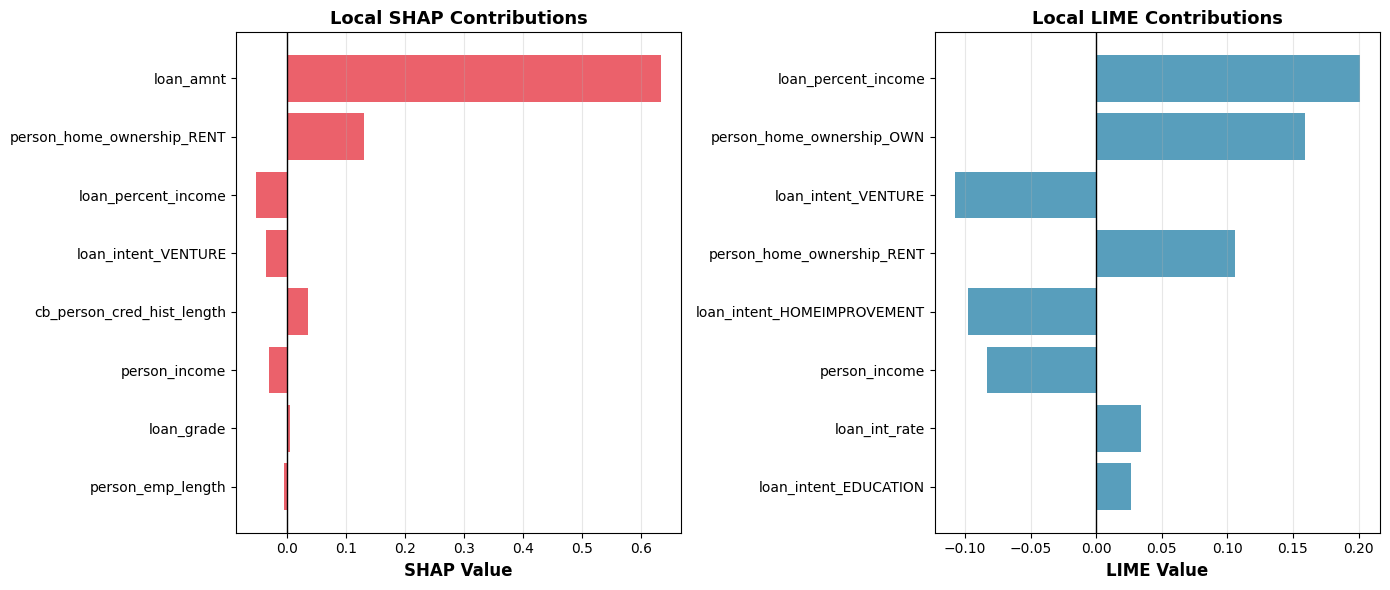

In [16]:
top_shap_features = shap_features[:8]
top_lime_features = lime_features[:8]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

if top_shap_features:
    shap_feat_names = [f['feature'] for f in top_shap_features]
    shap_vals = [f['shap_value'] for f in top_shap_features]
    axes[0].barh(range(len(shap_feat_names)), shap_vals, color='#E63946', alpha=0.8)
    axes[0].set_yticks(range(len(shap_feat_names)))
    axes[0].set_yticklabels(shap_feat_names, fontsize=10)
    axes[0].set_xlabel('SHAP Value', fontsize=12, fontweight='bold')
    axes[0].set_title('Local SHAP Contributions', fontsize=13, fontweight='bold')
    axes[0].axvline(0, color='black', linewidth=1)
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()

if top_lime_features:
    lime_feat_names = [f['feature'] for f in top_lime_features]
    lime_vals = [f['impact'] for f in top_lime_features]
    axes[1].barh(range(len(lime_feat_names)), lime_vals, color='#2E86AB', alpha=0.8)
    axes[1].set_yticks(range(len(lime_feat_names)))
    axes[1].set_yticklabels(lime_feat_names, fontsize=10)
    axes[1].set_xlabel('LIME Value', fontsize=12, fontweight='bold')
    axes[1].set_title('Local LIME Contributions', fontsize=13, fontweight='bold')
    axes[1].axvline(0, color='black', linewidth=1)
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


## Risk Probability Distribution

Show where this prediction falls relative to typical risk levels.


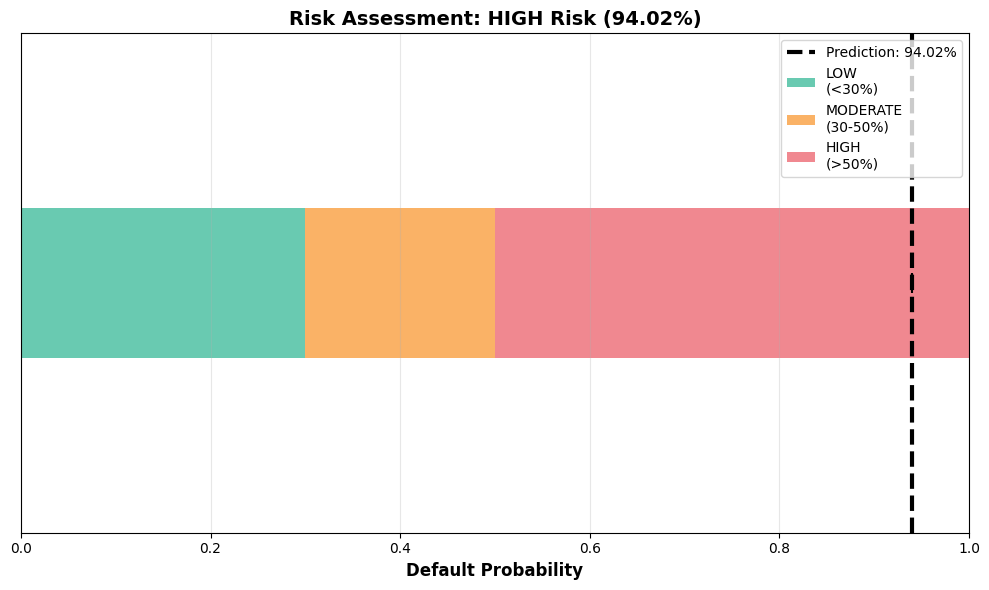

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

risk_ranges = ['LOW\n(<30%)', 'MODERATE\n(30-50%)', 'HIGH\n(>50%)']
risk_colors = ['#06A77D', '#F77F00', '#E63946']
risk_thresholds = [0.0, 0.3, 0.5, 1.0]

for i in range(len(risk_ranges)):
    ax.barh(0, risk_thresholds[i+1] - risk_thresholds[i], 
            left=risk_thresholds[i], color=risk_colors[i], alpha=0.6, 
            label=risk_ranges[i], height=0.3)

ax.axvline(final_probability, color='black', linewidth=3, linestyle='--', 
           label=f'Prediction: {final_probability:.2%}')
ax.scatter([final_probability], [0], s=200, color='black', zorder=5, marker='|')

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Default Probability', fontsize=12, fontweight='bold')
ax.set_title(f'Risk Assessment: {risk_level} Risk ({final_probability:.2%})', 
             fontsize=14, fontweight='bold')
ax.set_yticks([])
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## Explanation Complete

In [18]:
print("=" * 60)
print("COMPREHENSIVE RISK ASSESSMENT")
print("=" * 60)
print(f"\nPredicted Default Probability: {final_probability:.4f} ({final_probability*100:.2f}%)")
print(f"Risk Level: {risk_level}")

print(f"\nTop 3 Risk Drivers:")
for i, item in enumerate(risk_increasing[:3], 1):
    print(f"  {i}. {item['feature']}: +{item['impact']:.4f}")

print(f"\nTop 3 Risk Mitigators:")
for i, item in enumerate(risk_decreasing[:3], 1):
    print(f"  {i}. {item['feature']}: -{item['impact']:.4f}")

print("\n" + "=" * 60)


COMPREHENSIVE RISK ASSESSMENT

Predicted Default Probability: 0.9402 (94.02%)
Risk Level: HIGH

Top 3 Risk Drivers:
  1. loan_amnt: +0.3297
  2. person_home_ownership_RENT: +0.1179
  3. person_home_ownership_OWN: +0.0815

Top 3 Risk Mitigators:
  1. loan_intent_VENTURE: -0.0720
  2. person_income: -0.0569
  3. loan_intent_HOMEIMPROVEMENT: -0.0503

